In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from util import evaluate

In [2]:
X_train = pd.read_parquet("./modelling_data/X_train.parquet")
y_train = pd.read_parquet("./modelling_data/y_train.parquet")["target"]
X_valid = pd.read_parquet("./modelling_data/X_validation.parquet")
y_valid = pd.read_parquet("./modelling_data/y_validation.parquet")["target"]
X_test = pd.read_parquet("./modelling_data/X_test.parquet")
y_test = pd.read_parquet("./modelling_data/y_test.parquet")["target"]

X_train = pd.concat([X_train, X_valid]).pct_change()[1:]
y_train_pct_change = pd.concat([y_train, y_valid]).pct_change()[1:]
X_test = pd.read_parquet("./modelling_data/X_test.parquet").pct_change()[1:]
y_test_pct_change = pd.read_parquet("./modelling_data/y_test.parquet")["target"].pct_change()[1:]

In [3]:
params = {
    "epsilon": [0, 0.25, 0.5, 0.75, 1],
    "C": [10, 100, 1000, 10000, 100000],
    "loss": ["epsilon_insensitive", "squared_epsilon_insensitive"],
    "dual": [True, False]
}

ts_split = TimeSeriesSplit(n_splits=5)

In [4]:
svr = LinearSVR(random_state=0)
searcher = GridSearchCV(svr, params, cv=ts_split.split(X_train), verbose=10, n_jobs=-1)
searcher.fit(X_train, y_train_pct_change)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/ajaypethani/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [-3.84016751e-02  1.24353169e-02 -3.37041764e-01 -5.83280801e-01
 -1.89109114e+00 -1.71512965e+00 -1.07558985e-03 -1.07558985e-03
 -1.07558985e-03 -1.07558985e-03             nan  2.36262928e-02
             nan -5.72632949e-01             nan -1.71513859e+00
             nan -1.07558985e-03             nan -1.07558985e-03
 -1.43521823e+00 -8.02869622e-02 -2.50635117e+00 -5.98754292e-01
 -1.89109114e+00 -1.87232028e+00 -1.07558985e-03 -1.07558985e-03
 -1.07558985e-03 -1.07558985e-03             nan  2.95332320e-02
             nan -5.93329930e-01             nan -1.87132973e+00
             nan -1.07558985e-03             nan -1.07558985e-03
 -6.16451020e+00 -2.96328685e+00 -2.81839574e+00 -1.94910789e+00
 -1.89109114e+00 -1.88920360e+00 -1.07558985e-03 -1.07558985e-03
 -1.07558985e-03 -1.07558985e-03             nan  3.31563827e-0

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fc0f5ad98d0>,
             estimator=LinearSVR(random_state=0), n_jobs=-1,
             param_grid={'C': [10, 100, 1000, 10000, 100000],
                         'dual': [True, False],
                         'epsilon': [0, 0.25, 0.5, 0.75, 1],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive']},
             verbose=10)

In [5]:
searcher.best_params_

{'C': 100000,
 'dual': False,
 'epsilon': 0,
 'loss': 'squared_epsilon_insensitive'}

In [6]:
model = searcher.best_estimator_
y_pred_pct_change = model.predict(X_test)
y_pred = y_test.shift()[1:]*(1 + y_pred_pct_change)

MAE = 4.490713746013681
MSE = 79.74455998076738
RMSE = 8.929980961948765
MAPE = 0.0346740815269896
R^2 = 0.6445520120206449
Explained Variance Score = 0.6450283320870207

Residuals summary stats
╒═══════╤══════════╕
│ count │    14533 │
├───────┼──────────┤
│ mean  │ 0.326898 │
├───────┼──────────┤
│ std   │   8.9243 │
├───────┼──────────┤
│ min   │ -66.0479 │
├───────┼──────────┤
│ 25%   │ -1.52981 │
├───────┼──────────┤
│ 50%   │ 0.201336 │
├───────┼──────────┤
│ 75%   │  2.09555 │
├───────┼──────────┤
│ max   │  382.784 │
╘═══════╧══════════╛

Deviation from mean of residuals
╒════════════╤══════════╤════════════╕
│ Interval   │   Actual │   Expected │
╞════════════╪══════════╪════════════╡
│ μ ± σ      │  85.2887 │       68.2 │
├────────────┼──────────┼────────────┤
│ μ ± 2σ     │  93.6145 │       95.4 │
├────────────┼──────────┼────────────┤
│ μ ± 3σ     │  97.6192 │       99.7 │
╘════════════╧══════════╧════════════╛

Jarque-Bera Test on Residuals
╒══════════════╤═══════════════╕

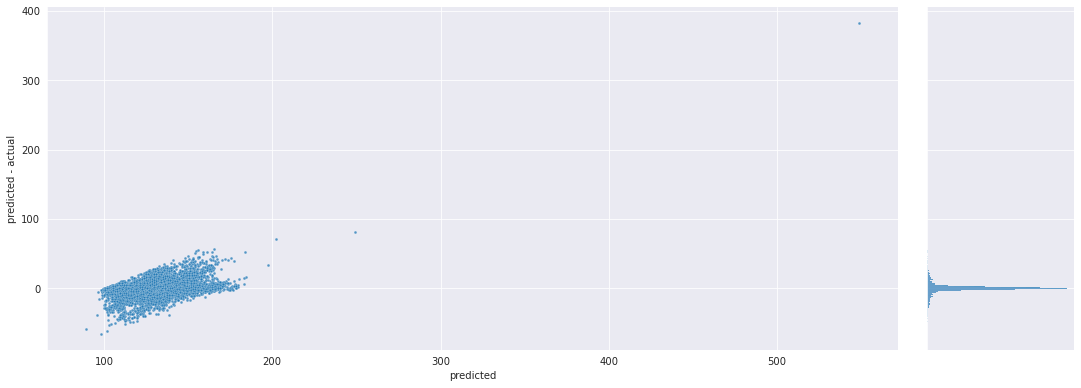

<Figure size 720x576 with 0 Axes>

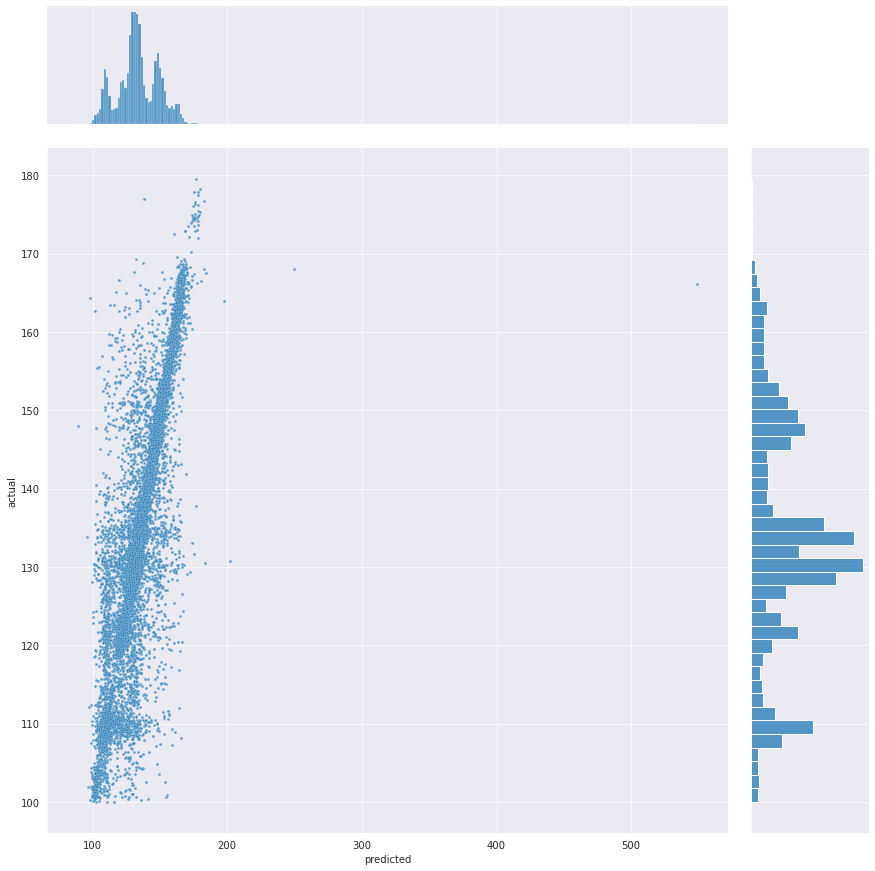

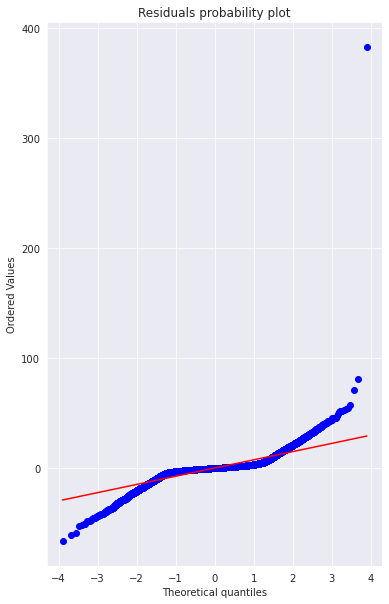

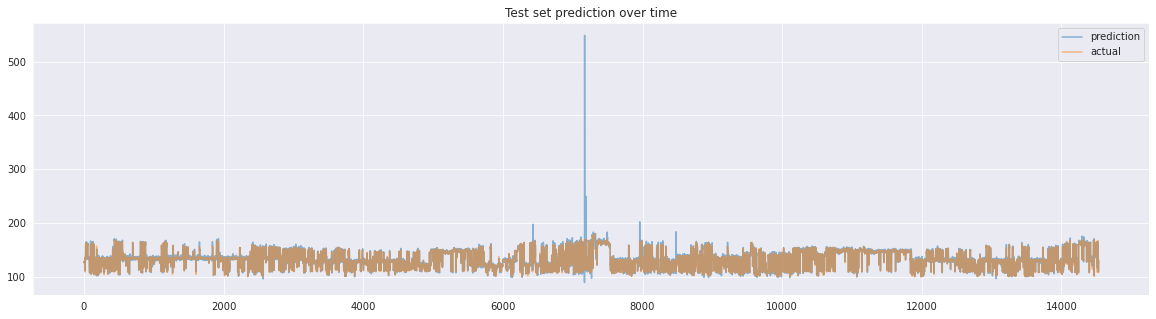

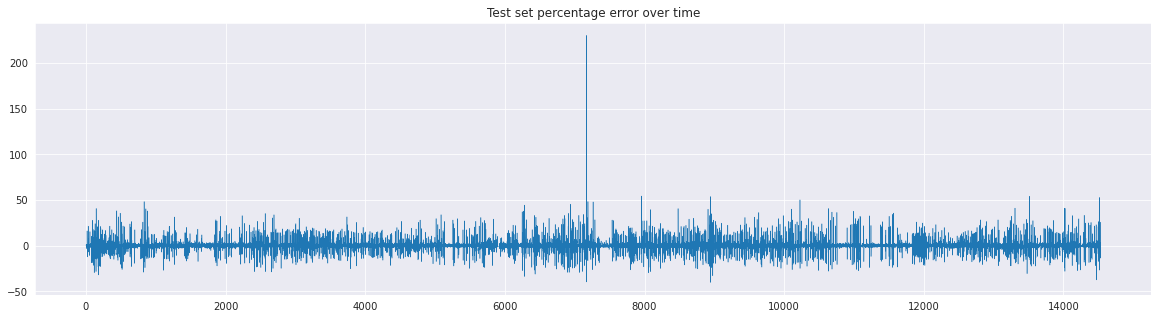

In [7]:
evaluate(y_test[1:].to_numpy(), y_pred.to_numpy())

In [8]:
pd.DataFrame(searcher.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_dual,param_epsilon,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
91,0.155815,0.074562,0.004329,0.000574,100000,False,0,squared_epsilon_insensitive,"{'C': 100000, 'dual': False, 'epsilon': 0, 'lo...",0.094657,0.064582,0.022173,-0.020704,0.008102,0.033762,0.041030,1
71,0.165943,0.090480,0.006590,0.002537,10000,False,0,squared_epsilon_insensitive,"{'C': 10000, 'dual': False, 'epsilon': 0, 'los...",0.094929,0.064593,0.021379,-0.020717,0.006700,0.033377,0.041340,2
51,0.192451,0.121445,0.004768,0.001607,1000,False,0,squared_epsilon_insensitive,"{'C': 1000, 'dual': False, 'epsilon': 0, 'loss...",0.094103,0.064052,0.021547,-0.020845,0.006924,0.033156,0.041007,3
31,0.138165,0.074906,0.004190,0.001530,100,False,0,squared_epsilon_insensitive,"{'C': 100, 'dual': False, 'epsilon': 0, 'loss'...",0.089921,0.058328,0.018383,-0.021886,0.002920,0.029533,0.039881,4
11,0.100157,0.053837,0.004335,0.000329,10,False,0,squared_epsilon_insensitive,"{'C': 10, 'dual': False, 'epsilon': 0, 'loss':...",0.075056,0.044421,0.017253,-0.020355,0.001755,0.023626,0.033259,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.009125,0.002158,0.000000,0.000000,10000,False,0.5,epsilon_insensitive,"{'C': 10000, 'dual': False, 'epsilon': 0.5, 'l...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,96
10,0.009209,0.002746,0.000000,0.000000,10,False,0,epsilon_insensitive,"{'C': 10, 'dual': False, 'epsilon': 0, 'loss':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,97
70,0.009137,0.002002,0.000000,0.000000,10000,False,0,epsilon_insensitive,"{'C': 10000, 'dual': False, 'epsilon': 0, 'los...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,98
30,0.007605,0.001622,0.000000,0.000000,100,False,0,epsilon_insensitive,"{'C': 100, 'dual': False, 'epsilon': 0, 'loss'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,99


In [9]:
y_pred.sort_values()

29360     89.308062
24759     95.784751
35256     96.413981
29461     97.071349
32302     98.285859
            ...    
29363    184.160517
28625    197.478746
30151    201.983553
29381    249.401171
29362    548.914141
Name: target, Length: 14533, dtype: float64

In [10]:
X_test.loc[29362]

AT      40.006587
AP      -0.000097
AH       0.022334
AFDP     0.218689
GTEP     0.248285
TIT      0.013265
TAT     -0.024061
TEY      0.140358
CDP      0.122596
CO      -0.228878
NOX     -0.215309
Name: 29362, dtype: float64

In [11]:
y_test.loc[29362]

166.13

MAE = 4.4735862333854834
MSE = 70.89555965594134
RMSE = 8.419950098185936
MAPE = 0.03457098447872501
R^2 = 0.6839949453297844
Explained Variance Score = 0.6844226602431382

Residuals summary stats
╒═══════╤══════════╕
│ count │    14533 │
├───────┼──────────┤
│ mean  │  0.30977 │
├───────┼──────────┤
│ std   │  8.41454 │
├───────┼──────────┤
│ min   │ -66.0479 │
├───────┼──────────┤
│ 25%   │ -1.52981 │
├───────┼──────────┤
│ 50%   │ 0.201336 │
├───────┼──────────┤
│ 75%   │  2.09555 │
├───────┼──────────┤
│ max   │   133.87 │
╘═══════╧══════════╛

Deviation from mean of residuals
╒════════════╤══════════╤════════════╕
│ Interval   │   Actual │   Expected │
╞════════════╪══════════╪════════════╡
│ μ ± σ      │  84.6556 │       68.2 │
├────────────┼──────────┼────────────┤
│ μ ± 2σ     │  92.9402 │       95.4 │
├────────────┼──────────┼────────────┤
│ μ ± 3σ     │  97.227  │       99.7 │
╘════════════╧══════════╧════════════╛

Jarque-Bera Test on Residuals
╒══════════════╤══════════════

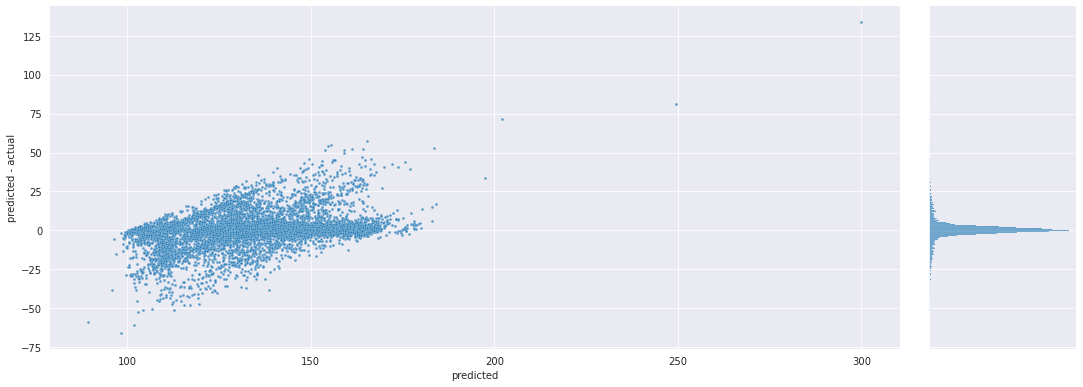

<Figure size 720x576 with 0 Axes>

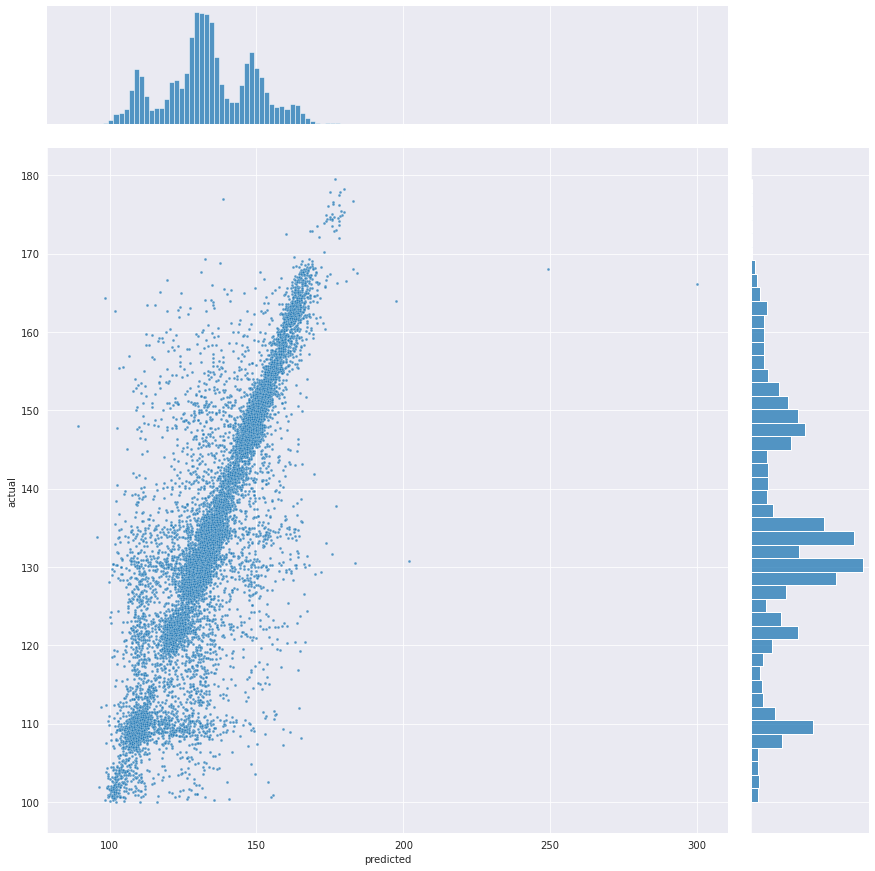

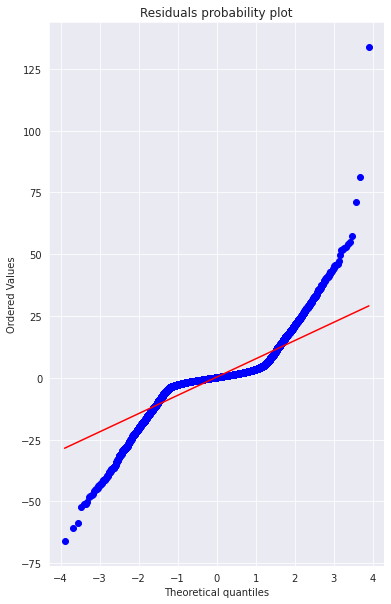

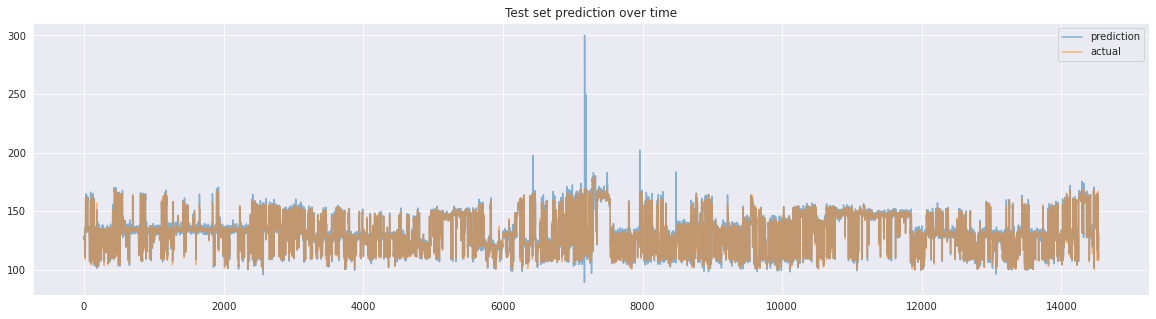

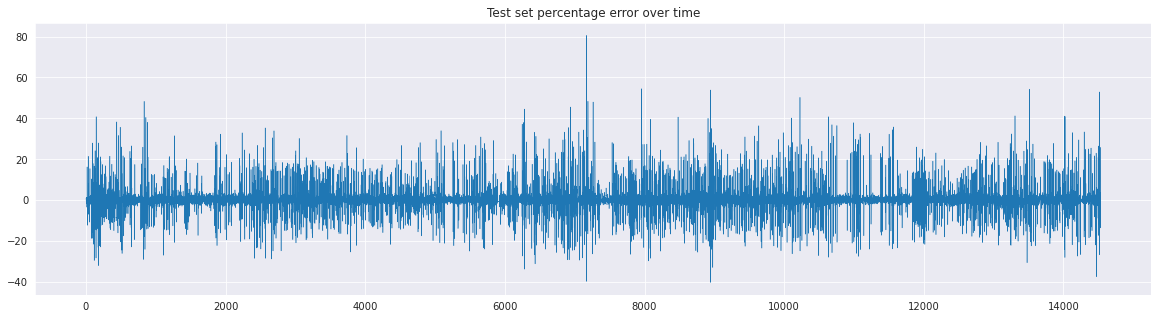

In [12]:
evaluate(y_test[1:].to_numpy(), y_pred.clip(upper=300).to_numpy())